In [1]:
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import pyrtools as pt
from tqdm import tqdm 
from wasserstein.basic_wasserstein import compute_sliced_wass_barycenter
from utils.image_treatment import preprocess_image, image_to_distribution
import matplotlib.pyplot as plt
import pickle
import ot
from joblib import Parallel, delayed

/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [169]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'

In [180]:
image1 = preprocess_image(image_path1, new_size = (200,200))
image2 = preprocess_image(image_path2, new_size = (200,200))
textures = [image1, image2]

In [21]:
def compute_sliced_wass_barycenter(distributions, rho = None, lr = 1e3, k = 200, nb_iter_max = 50, xbinit = None):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    distributions = [x.astype(np.float64) for x in distributions]
    x_torch = [torch.tensor(x).to(device=device) for x in distributions]
    #print(distributions[0].dtype)

    if rho is None: 
        n = len(distributions)
        rho = n*[1/n]
    
    if xbinit is None:
        #xbinit = np.random.randn(500, 2) * 10 + 16 #initialization
        xbinit = np.random.normal(0., 1., distributions[0].shape)
    xbary_torch = torch.tensor(xbinit).to(device=device).requires_grad_(True)
    #print(xbinit.dtype)


    x_all = np.zeros((nb_iter_max, xbary_torch.shape[0], xbary_torch.shape[1]))

    loss_iter = []

    # generator for random permutations
    gen = torch.Generator(device=device)
    gen.manual_seed(42)


    for i in tqdm(range(nb_iter_max)):

        loss = 0
        for i, x in enumerate(x_torch):
            loss += rho[i] * ot.sliced_wasserstein_distance(xbary_torch, x, n_projections=1, seed=gen)
        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        # performs a step of projected gradient descent
        with torch.no_grad():
            grad = xbary_torch.grad
            xbary_torch -= grad * lr  # / (1 + i / 5e1)  # step
            xbary_torch.grad.zero_()
            x_all[i, :, :] = xbary_torch.clone().detach().cpu().numpy()

    xb = xbary_torch.clone().detach().cpu().numpy()
    return(xb)

In [16]:
flattened_img1 = image1.reshape(-1, 3)
flattened_img2 = image2.reshape(-1, 3)
textures = [flattened_img1, flattened_img2]


compute_sliced_wass_barycenter(textures, rho = None, lr = 1e3, k = 200, nb_iter_max = 50, xbinit = None)

100%|██████████| 50/50 [00:02<00:00, 20.48it/s]


array([[ 0.89478372,  0.87612986, -1.80084029],
       [-0.11004639, -0.98949071,  0.22451589],
       [ 1.41845563,  0.65332722, -0.36433182],
       ...,
       [ 2.72148365, -0.25331965, -0.05811761],
       [ 0.80062477, -0.06526036,  0.9291494 ],
       [-0.20831757, -0.83008363, -0.78553146]])

### Pyramid

In [3]:
def initialize_random_image(size=(256, 256), channels=3):
    """Initialize a random white noise image f^(0)."""
    return np.random.rand(*size, channels)

In [4]:
def projection(X0, Y, nb_iter_max=1000):
    """
    X0 : image a projeter 
    Y : ce sur quoi on veut projeter 
    """
    Y_distrib = [Y]
    proj = compute_sliced_wass_barycenter(Y_distrib, rho = None, lr = 1e3, k = 200,  nb_iter_max = nb_iter_max, xbinit = X0)
    return(proj)

In [5]:
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [6]:
def from_dict_to_RGB_array(dico):

    output_dict = {}

    # Extract unique filter types by parsing keys
    filters = set(key.split('.')[1] for key in dico.keys())

    # Iterate through each unique filter
    for filter_type in filters:
        # Collect the R, G, B arrays for the current filter
        r_key = f'R.{filter_type}'
        g_key = f'G.{filter_type}'
        b_key = f'B.{filter_type}'
        
        if r_key in dico and g_key in dico and b_key in dico:
            # Stack R, G, B arrays along a new third axis to form a (P, Q, 3) array
            rgb_array = np.stack([dico[r_key], dico[g_key], dico[b_key]], axis=-1)
            
            # Add to output dictionary
            output_dict[filter_type] = rgb_array
    return(output_dict)


# TESTS 
1 - Tester les Y

2 - Tester que la version accélérée renvoie bien les bons résultats 

3 - Tester que les Y_l sont bien corrects avec la fonction qui durent 35 min 

## 1 - Test des Y

100%|██████████| 5000/5000 [01:22<00:00, 60.89it/s]


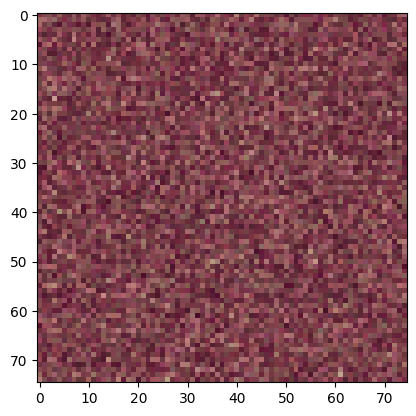

In [179]:
flattened_img1 = image1.reshape(-1, 3)
flattened_img2 = image2.reshape(-1, 3)
textures = [flattened_img1, flattened_img2]

Y = compute_sliced_wass_barycenter(textures, rho=[1/2,1/2], nb_iter_max=5000)
Y = Y.reshape(75,75,3)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

100%|██████████| 10000/10000 [16:29<00:00, 10.11it/s]


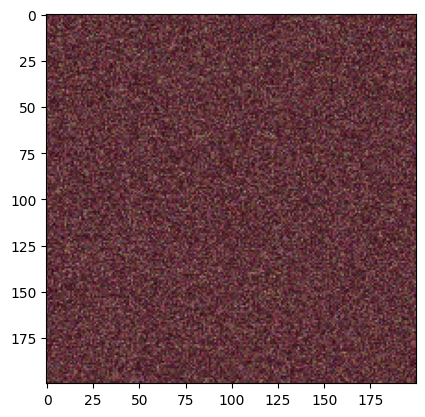

In [20]:
flattened_img1 = image1.reshape(-1, 3)
flattened_img2 = image2.reshape(-1, 3)
textures = [flattened_img1, flattened_img2]

Y = compute_sliced_wass_barycenter(textures, rho=[1/2,1/2], nb_iter_max=10000)
Y = Y.reshape(200,200,3)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

100%|██████████| 10000/10000 [07:13<00:00, 23.06it/s]


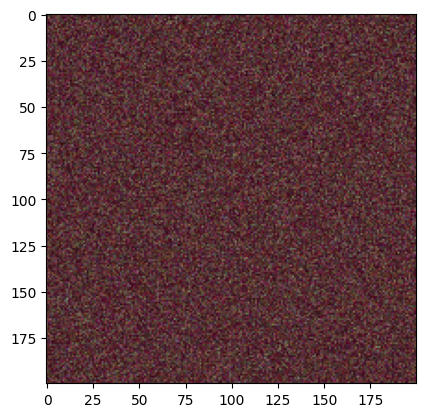

In [17]:
flattened_img1 = image1.reshape(-1, 3)
flattened_img2 = image2.reshape(-1, 3)
textures = [flattened_img1, flattened_img2]

Y = compute_sliced_wass_barycenter(textures, rho=[1/2,1/2], nb_iter_max=10000)
Y = Y.reshape(200,200,3)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

100%|██████████| 7000/7000 [05:34<00:00, 20.90it/s]


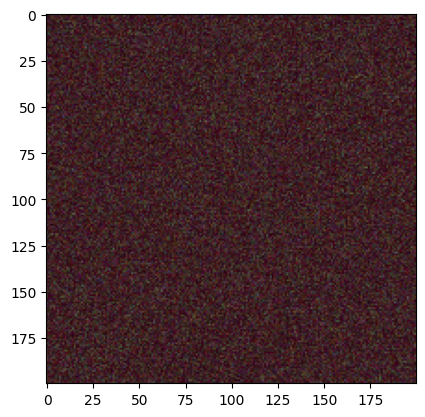

In [18]:
flattened_img1 = image1.reshape(-1, 3)
flattened_img2 = image2.reshape(-1, 3)
textures = [flattened_img1, flattened_img2]

Y = compute_sliced_wass_barycenter(textures, rho=[1/2,1/2], nb_iter_max=7000)
Y = Y.reshape(200,200,3)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

100%|██████████| 2000/2000 [00:30<00:00, 65.70it/s]


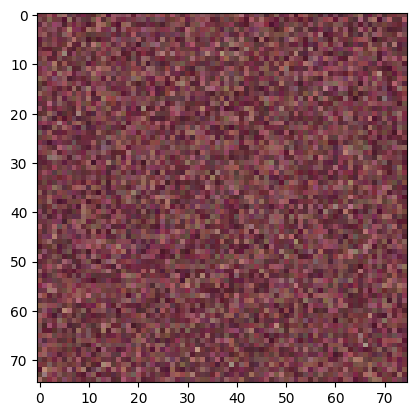

In [178]:
flattened_img1 = image1.reshape(-1, 3)
flattened_img2 = image2.reshape(-1, 3)
textures = [flattened_img1, flattened_img2]

Y = compute_sliced_wass_barycenter(textures, rho=[1/2,1/2], nb_iter_max=2000)
Y = Y.reshape(75,75,3)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

In [13]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'
size = 200
image1 = preprocess_image(image_path1, new_size = (size,size))
image2 = preprocess_image(image_path2, new_size = (size,size))
textures = [image1, image2]

# 2 - Test des Y_l 

Calcul des Y_l 

In [7]:
def compute_steerable_pyramid_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute steerable pyramid coefficients with specified orientations using pyrtools.
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - coeffs: Dictionary of coefficients organized by scale and orientation.
    """
    # Initialize the steerable pyramid
    pyramid = pt.pyramids.SteerablePyramidFreq(image, height=num_scales, order=num_orientations-1)

    return pyramid.pyr_coeffs, pyramid

In [8]:
def compute_3D_wavelets_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute wavelets coefficients (highpass, bandpass, low-residuals) for the 3 channels (R,G,B) of an image
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - wavelets_coeffs: Dictionary of coefficients organized by channel (R,G,B) and then by bandpass (highpass, bandpass -scale and orientation- and low residual).
    """
    wavelets_coeffs = {}
    rgb = ['R','G','B']
    for channel in range(3):
        wavelets_coeffs[rgb[channel]], _ = compute_steerable_pyramid_coeffs(image[:, :, channel], num_scales=num_scales, num_orientations=num_orientations)
    return(wavelets_coeffs)

In [9]:

def regroup_channels(data):
    """
    Regroupe les canaux R, G, B en concaténant leurs valeurs pour obtenir des clés uniques.
    
    Paramètres :
    data (dict) : Dictionnaire d'origine avec des clés de la forme 'R.(i, j)', 'G.(i, j)', etc.,
                  où chaque valeur est un tableau de taille (75, 75).
                  
    Retourne :
    dict : Nouveau dictionnaire avec des clés regroupées et des valeurs de taille (75, 75, 3).
    """
    
    # Initialisation du nouveau dictionnaire
    new_data = {}
    
    # Liste des types de clés à regrouper
    key_types = ['residual_highpass', 'residual_lowpass'] + [f'({i}, {j})' for i in range(4) for j in range(4)]
    
    # Parcours de chaque type de clé pour regrouper les canaux
    for key_type in key_types:
        r_key = f'R.{key_type}'
        g_key = f'G.{key_type}'
        b_key = f'B.{key_type}'
        
        # Vérifier que les clés existent dans le dictionnaire d'origine
        if r_key in data and g_key in data and b_key in data:
            # Concaténer les canaux R, G, B le long de l'axe des couleurs (axis=-1)
            new_data[key_type] = np.stack((data[r_key], data[g_key], data[b_key]), axis=-1)
    
    return new_data


# Cleancode 

In [10]:
def compute_Y_l(image1, image2, rho=None, nb_iter_max=2000):
    # Calcul des Y_l_1 et Y_l_2
    wavelet_coefs_1 = compute_3D_wavelets_coeffs(image1, num_scales=4, num_orientations=4)
    wavelet_coefs_1 = flatten_dict(wavelet_coefs_1)
    wavelet_coefs_1 = regroup_channels(wavelet_coefs_1)

    wavelet_coefs_2 = compute_3D_wavelets_coeffs(image2, num_scales=4, num_orientations=4)
    wavelet_coefs_2 = flatten_dict(wavelet_coefs_2)
    wavelet_coefs_2 = regroup_channels(wavelet_coefs_2)

    # Calcul des Y_l en parallèle
    def compute_barycenter_for_key(key):
        textures = [wavelet_coefs_1[key], wavelet_coefs_2[key]]
        textures = [x.reshape(-1,3) for x in textures]
        return key, compute_sliced_wass_barycenter(textures, rho=rho, nb_iter_max=nb_iter_max)
    
    results = Parallel(n_jobs=-1)(delayed(compute_barycenter_for_key)(key) for key in tqdm(wavelet_coefs_1.keys()))
    
    Y_l = {key: result for key, result in results}
    Y_l = flatten_dict(Y_l)
    return Y_l

def compute_Y(textures, size, nb_iter_max=2000, rho=None):
    textures = [x.reshape(-1, 3) for x in textures]
    Y = compute_sliced_wass_barycenter(textures, rho=rho, nb_iter_max=nb_iter_max)
    Y = Y.reshape(size,size,3)
    return Y

In [11]:
def convert_keys(d):
    new_dict = {}
    for key, value in d.items():
        if key=="residual_highpass" or key=='residual_lowpass':
            new_dict[key] = value
        elif isinstance(key, str):  # Si la clé est une chaîne
            # Convertir la chaîne en tuple
            new_key = tuple(map(int, key.strip('()').split(',')))
            new_dict[new_key] = value
        else:
            new_dict[key] = value
    return new_dict

In [22]:
from joblib import Parallel, delayed
from tqdm import tqdm


def texture_synthesis(image1, image2, rho= None, nb_iter_max_bary=10000, nb_iter_max_proj=5000, num_iterations=1):
    textures = [image1, image2]
    size = textures[0].shape[0]

    Y_l = compute_Y_l(image1, image2, nb_iter_max=nb_iter_max_bary,  rho=rho)
    print("______ Y_l calculés : calcul de Y______")
    Y = compute_Y(textures, size, nb_iter_max=nb_iter_max_bary, rho=rho)
    print("______ Y et Y_l calculés ______")

    # Démarrer avec une image bruitée initiale
    f_k = np.random.randn(size, size, 3)

    for k in range(num_iterations):
        # Étape 1 : calculer les coefficients pyramidaux steerables
        pyramid_coeffs = compute_3D_wavelets_coeffs(f_k, num_scales=4, num_orientations=4)
        pyramid_coeffs = flatten_dict(pyramid_coeffs)
        pyramid_coeffs = regroup_channels(pyramid_coeffs)

        # Étape 2 : appliquer les contraintes de distribution par projection ==> CALCUL DES C_L_N
        # Utiliser Parallel pour paralléliser les calculs
        results = Parallel(n_jobs=-1)(
            delayed(process_projection)(key, pyramid_coeffs[key].reshape(-1,3), Y_l[key], nb_iter_max_proj)
            for key in tqdm(pyramid_coeffs.keys())
        )


        # Mettre à jour pyramid_coeffs avec les résultats
        for key, projected_coeffs in results:
            size_pyr = int(np.sqrt(projected_coeffs.shape[0]))
            pyramid_coeffs[key] = projected_coeffs.reshape(size_pyr,size_pyr,3)

        # Étape 3 : calcul de f tilde 
        pyramid_barycenter_r = {}
        pyramid_barycenter_g = {}
        pyramid_barycenter_b = {}
        for key in pyramid_coeffs.keys(): #pour chaque coefficient (qui est pour l'instant en RGB)
            #il faut extraire les coefficients pour R, G et B
            pyramid_barycenter_r[key] = pyramid_coeffs[key][:,:,0]
            pyramid_barycenter_g[key] = pyramid_coeffs[key][:,:,1]
            pyramid_barycenter_b[key] = pyramid_coeffs[key][:,:,2]

        pyramid_barycenter_r = convert_keys(pyramid_barycenter_r)
        pyramid_barycenter_g = convert_keys(pyramid_barycenter_g)
        pyramid_barycenter_b = convert_keys(pyramid_barycenter_b)


        #puis on reconstruit les images a partir de chaque pyramide R, G et B
        noise = np.random.randn(size, size)
        noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise, height=4, order=3)

        noisy_pyr.pyr_coeffs = pyramid_barycenter_r
        reconstructed_pyr_r = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyramid_barycenter_g
        reconstructed_pyr_g = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyramid_barycenter_b
        reconstructed_pyr_b = noisy_pyr.recon_pyr()

        # Étape 4 : reconstruction de l'image en projetant
        reconstructed_image = np.stack([reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b], axis=-1)
        f_k = projection(reconstructed_image.reshape(-1,3), Y.reshape(-1,3), nb_iter_max= nb_iter_max_proj ).reshape((size,size,3))
        f_k_image = np.clip(f_k, 0, 255).astype(np.uint8) # assure que les valeurs sont comprises entre 0 et 255 et sont des entiers
        plt.imshow(f_k_image)
        plt.show()

    return f_k_image


# Définir une fonction pour traiter chaque élément de la boucle
def process_projection(key, current_dist, target_dist, nb_iter_max_proj):
    return key, projection(current_dist, target_dist, nb_iter_max=nb_iter_max_proj)

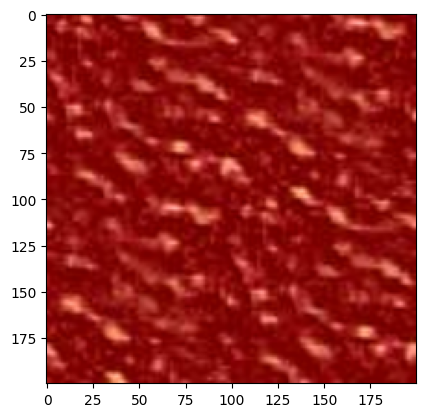

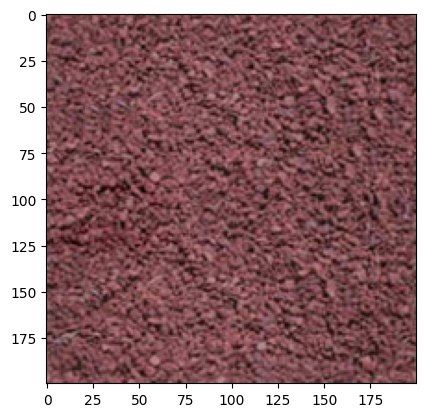

0it [00:00, ?it/s]

/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://g

______ Y_l calculés : calcul de Y______


______ Y et Y_l calculés ______




/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/t

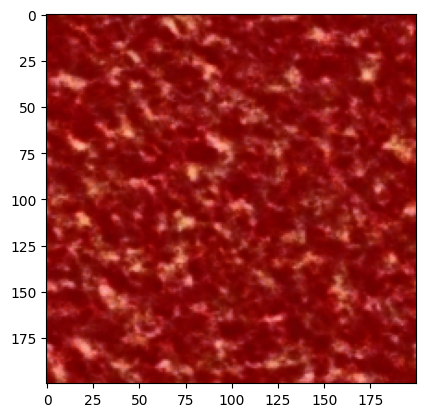

1it [45:11, 2711.45s/it]

/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    htt

______ Y_l calculés : calcul de Y______


______ Y et Y_l calculés ______




/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/t

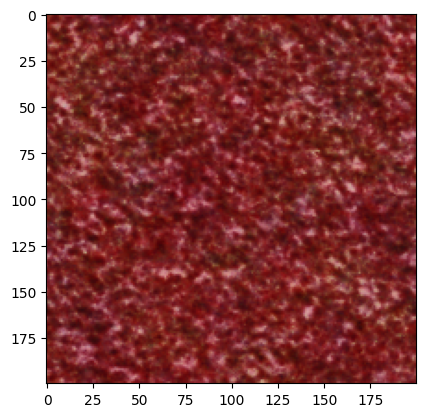

2it [1:30:58, 2732.11s/it]

/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    h

______ Y_l calculés : calcul de Y______


______ Y et Y_l calculés ______




/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/t

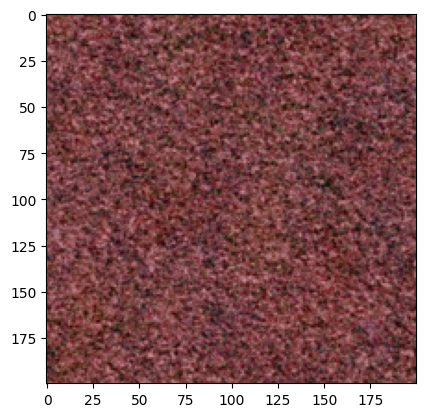

3it [2:48:26, 3368.90s/it]


In [29]:
image_path1 = 'data/smallRed.jpg'
image_path2 = 'data/PebbleGround.png'
size = 200
image1 = preprocess_image(image_path1, new_size = (size,size))
image2 = preprocess_image(image_path2, new_size = (size,size))
textures = [image1, image2]

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

textures = [image1, image2]

rho_values = [[3/4, 1/4], [1/2, 1/2], [1/4, 3/4]]

final_texture = []
# Boucle sur les valeurs de `rho` pour afficher les images générées
for i, rho in tqdm(enumerate(rho_values, start=1)):
   reconstructed_image = texture_synthesis(image1, image2, rho=rho, nb_iter_max_bary=15000, nb_iter_max_proj=15000, num_iterations=1)
   final_texture.append(reconstructed_image)

Text(0.5, 1.0, 'Original $f^2$')

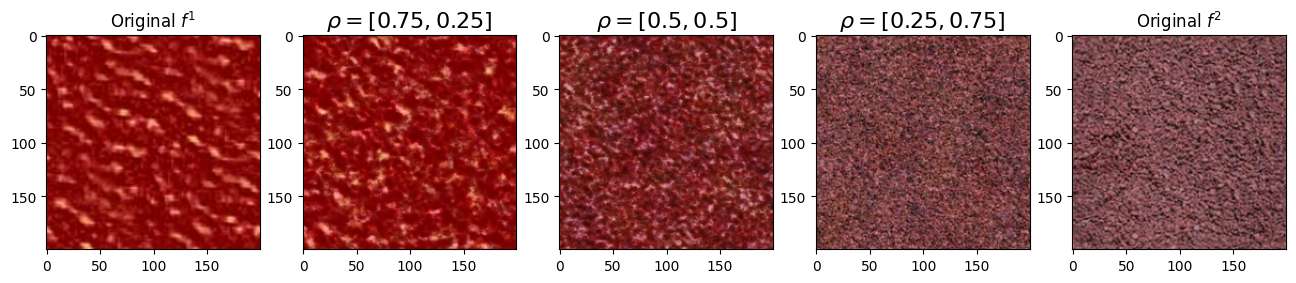

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1,5,1)
plt.imshow(image1)
plt.title('Original $f^1$')
for i in range(len(final_texture)):
    plt.subplot(1,5,i+2)
    plt.imshow(final_texture[i])
    plt.title(f'$\\rho = {rho_values[i]}$', fontsize=16)
plt.subplot(1,5,5)
plt.imshow(image2)
plt.title('Original $f^2$')

## Problème : 15 000 itérations : trop long à compute 